# Introduction

This notebook trains a linear discriminant analysis model on preprocessed EEG data to predict behavioral data from neural features.

An example of this can be found in the paper, "Human stereoEEG recordings reveal network dynamics of decision-making in a rule-switching task" by Wal et al.

Behavioral data and preprocessed neural data from Subject 06 in the NCSL EFRI datasetwill be used in this notebook.

## Imports

In [41]:
import h5py 
import mat73
import numpy as np
import mne
from matplotlib import pyplot as plt
from sklearn.model_selection import cross_val_predict
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from scipy.stats import ttest_ind

## Load File Paths

In [4]:
# ncsl_share = '/run/user/1000/gvfs/smb-share:server=10.162.37.21,share=main'
# data_path = f'Data/Subject06_snapshot_normalized.npy'
ncsl_share = '/mnt/ncsl_share'
data_path = ncsl_share + f'/Daniel/Data/Trial_by_Chan_by_Freq_by_Time_Snapshots/Subject06_snapshot_normalized.npy'
setup_path = ncsl_share + f'/Public/EFRI/1_formatted/SUBJECT06/EFRI06_WAR_SES1_Setup.mat'
raw_path = ncsl_share + f'/Public/EFRI/1_formatted/SUBJECT06/EFRI06_WAR_SES1_Raw.mat'
out_path_tvalues = f't_values'

raw_file = h5py.File(raw_path)
setup_data = mat73.loadmat(setup_path)

In [ ]:
setup_data['filters'].keys()

## Instantiate variables

In [5]:
bets = setup_data['filters']['bets']

good_trials = np.where(np.isnan(bets) == False)[0] # extract indices of trials without the 'nan'

bets = bets[good_trials] # get the bet values for the good trials
subject_cards = setup_data['filters']['card1'][good_trials] # get the subject's card values for the good trials

In [6]:
data = np.load(data_path)
num_trials, num_channels, num_freqs, num_timesteps = data.shape

In [7]:
y = np.asarray([(0 if bet == 5 else 1) for bet in bets]) # 0 = low bet ($5), 1 = high bet ($20)

## Model Training

Using the power per wavelet scale for a particular channel and timepoint as a feature. 

In [42]:
model_accuracies = np.zeros((num_channels, num_timesteps, 5))
t_values = np.zeros((num_channels,num_timesteps))
prob_values = np.zeros((num_channels, num_timesteps, num_trials, 2))
decision_values = np.zeros((num_channels,num_timesteps,num_trials))

In [43]:
# Trains an LDA model on preprocessed data, implements cross validation, and extracts decision values  
for channel in range(num_channels):
    for time in range(num_timesteps):
        X = data[:, channel, :, time] # get the EEG data for a particular channel and time point

        lda = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto')
        # cv_results = np.zeros(10,5)
        # for i in range(10):
        #     cv_results[i] = cross_val_predict(lda, X, y, cv=5, return_estimator=True)
        
        # model_accuracies[channel, time] = cv_results['test_score'] # store the accuracies of the cross-validated model
        # max_index = list(model_accuracies[channel,time]).index(model_accuracies[channel,time].max()) 
        # best_lda = cv_results['estimator'][max_index] # select the best performing model after cross-validation
        
        # decision_values[channel,time] = best_lda.decision_function(X)
        prob_values[channel,time] = cross_val_predict(lda, X, y, cv=5, method = 'predict_log_proba') # calculate the log of probabilities for classification of each class (ie decision value for each class)
        t_values[channel,time] = ttest_ind(prob_values[channel,time,:,0],prob_values[channel,time,:,1]).statistic # perform t-test on log prob values (ie decision values for each class)

In [37]:
import math
sanity_check = prob_values[:,:,:,1] - prob_values[:,:,:,0]
for i in range(num_trials):
    if not math.isclose(sanity_check[0,0,i], decision_values[0,0,i],rel_tol=1e-9):
        print('Contradiction in calculated decision values!')

In [38]:
sanity_check

array([[[-7.19570749e-02, -2.39545076e+00, -1.89675731e+00, ...,
          4.39758592e-01, -2.28695674e-01,  2.47586090e-01],
        [ 8.21020382e-01, -1.29612267e+00, -1.02271754e+00, ...,
          2.04939786e-01, -1.10852494e-01,  6.58514784e-01],
        [ 2.78160702e-01, -2.34801968e+00, -1.68161436e+00, ...,
          4.83847997e-01, -9.70800810e-01, -7.37978971e-01],
        ...,
        [ 2.70316355e-01, -1.55381261e+00,  4.87925465e-01, ...,
          4.19677623e-01, -1.27812912e+00,  2.13753836e-02],
        [ 9.50307947e-01, -1.83296285e+00, -1.29867406e+00, ...,
          1.04006649e+00, -9.78121511e-01, -1.19851038e+00],
        [-1.19988464e+00, -2.69014165e+00, -1.35617031e-01, ...,
          5.76445989e-01, -5.51568712e-01, -1.04718888e+00]],

       [[-9.65207047e-01, -2.13274352e+00, -1.88257460e+00, ...,
          2.20985548e-01, -1.93544558e+00, -4.03260997e-01],
        [ 1.68122369e-01, -1.63749064e+00, -1.30671691e+00, ...,
         -8.32912741e-02, -2.63460619e

In [39]:
decision_values

array([[[-7.19570749e-02, -2.39545076e+00, -1.89675731e+00, ...,
          4.39758592e-01, -2.28695674e-01,  2.47586090e-01],
        [ 8.21020382e-01, -1.29612267e+00, -1.02271754e+00, ...,
          2.04939786e-01, -1.10852494e-01,  6.58514784e-01],
        [ 2.78160702e-01, -2.34801968e+00, -1.68161436e+00, ...,
          4.83847997e-01, -9.70800810e-01, -7.37978971e-01],
        ...,
        [ 2.70316355e-01, -1.55381261e+00,  4.87925465e-01, ...,
          4.19677623e-01, -1.27812912e+00,  2.13753836e-02],
        [ 9.50307947e-01, -1.83296285e+00, -1.29867406e+00, ...,
          1.04006649e+00, -9.78121511e-01, -1.19851038e+00],
        [-1.19988464e+00, -2.69014165e+00, -1.35617031e-01, ...,
          5.76445989e-01, -5.51568712e-01, -1.04718888e+00]],

       [[-9.65207047e-01, -2.13274352e+00, -1.88257460e+00, ...,
          2.20985548e-01, -1.93544558e+00, -4.03260997e-01],
        [ 1.68122369e-01, -1.63749064e+00, -1.30671691e+00, ...,
         -8.32912741e-02, -2.63460619e

In [44]:
print(prob_values[0][0])
print(t_values[0][0])

[[-1.09538332 -0.40708351]
 [-0.21533824 -1.64128305]
 [-0.28153636 -1.40496142]
 [-0.24667514 -1.52048651]
 [-0.84681962 -0.55997462]
 [-0.13311638 -2.08235143]
 [-0.15913304 -1.91652631]
 [-0.07971538 -2.56888561]
 [-0.2603313  -1.47314363]
 [-0.58133829 -0.81904961]
 [-0.93029547 -0.50159692]
 [-0.40412858 -1.10129071]
 [-0.07109083 -2.67913176]
 [-1.07484824 -0.41756232]
 [-1.04832255 -0.43159131]
 [-0.69073932 -0.69556086]
 [-0.19454014 -1.73281043]
 [-0.05876268 -2.86348581]
 [-0.42356293 -1.06337057]
 [-0.11445148 -2.22428426]
 [-1.10155046 -0.40399926]
 [-1.08194462 -0.41390429]
 [-1.0498217  -0.43078315]
 [-0.08905359 -2.46271328]
 [-0.53566749 -0.88014805]
 [-1.38378397 -0.28852027]
 [-0.69466477 -0.69163189]
 [-0.25333243 -1.49704629]
 [-0.42591302 -1.05892963]
 [-0.45266237 -1.01041683]
 [-0.52873754 -0.89001043]
 [-0.77640873 -0.61628843]
 [-0.92385825 -0.50581224]
 [-0.18377645 -1.78451661]
 [-0.97179092 -0.4754661 ]
 [-0.8333646  -0.57019463]
 [-0.74596898 -0.64297609]
 

<function matplotlib.pyplot.show(close=None, block=None)>

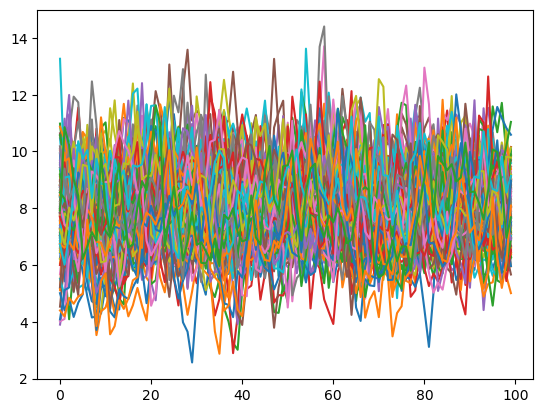

In [48]:
for i in range(len(t_values)):
    plt.plot(t_values[i])
plt.show

In [33]:
ttest_ind(prob_values[0,0,:,0],prob_values[0,0,:,1])

Ttest_indResult(statistic=8.579377590445121, pvalue=2.70218496535644e-16)

In [29]:
def train_LDA_model(data, y, channel, time):
    X = data[:, channel, :, time] # get the EEG data for a particular channel and time point

    lda = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto')
    cv_results = cross_val_score(lda, X, y, cv=5, return_estimator=True)
    
    accuracies = cv_results['test_score'] # store the accuracies of the cross-validated model
    max_index = list(accuracies).index(accuracies.max()) 
    best_lda = cv_results['estimator'][max_index] # select the best performing model after cross-validation
    
    probabilities = best_lda.predict_log_proba(X) # calculate the log of probabilities for classification of each class (ie decision value for each class)
    t_values = ttest_ind(probabilities[:,0],probabilities[:,1]).statistic # perform t-test on log prob values (ie decision values for each class)
    return accuracies, probabilities, t_values

## Calculating t-statistic

In [ ]:
np.save(f'{out_path_tvalues}/Subject06_tvalues.npy',t_values) # save t-values

In [ ]:
subject06_tvalues = np.load('t_values/Subject06_tvalues.npy')
subject07_tvalues = np.load('t_values/Subject07_tvalues.npy')

print(subject07_tvalues[3])
# print(ttest_ind(subject06_tvalues,subject07_tvalues).statistic)

## Reshuffling of Data

In [ ]:
# Get the indices for each of the card values in subject_cards
card_value_indices = []
for i in [2,4,6,8,10]:
    card_value_indices.append(np.where(subject_cards == i)[0])

In [ ]:
y_shuffled = np.zeros(y.shape)
for indices in card_value_indices:
    temp = indices
    num_high_bets = y[indices].sum() + round(np.random.uniform(-1,1)*y[indices].sum()*.2)
    for j in range(num_high_bets):
        if np.any(temp):
            rand = np.random.choice(temp)
            y_shuffled[rand] = 1
            rand_index = np.where(temp == rand)[0]
            temp = np.delete(temp,rand_index)
    y_shuffled[temp] = 0

In [ ]:
for i in range(len(card_value_indices)):
    print(y_shuffled[card_value_indices[i]].sum()/len(card_value_indices[i]))

In [30]:
def shuffle_y(y):
    # Get the indices for each of the card values in subject_cards
    card_value_indices = []
    for i in [2,4,6,8,10]:
        card_value_indices.append(np.where(subject_cards == i)[0])

    y_shuffled = np.zeros(y.shape)
    for indices in card_value_indices:
        temp = indices
        num_high_bets = y[indices].sum() + round(np.random.uniform(-1,1)*y[indices].sum()*0.2) # (1-alpha) is how much 
        for j in range(num_high_bets):
            if np.any(temp):
                rand = np.random.choice(temp)
                y_shuffled[rand] = 1
                rand_index = np.where(temp == rand)[0]
                temp = np.delete(temp,rand_index)
        y_shuffled[temp] = 0

    return y_shuffled

## Multiprocessing

In [32]:
def get_t_values(data, y, num_channels, num_timesteps, num_trials):
    np.random.seed()
    model_accuracies = np.zeros((num_channels, num_timesteps, 5))
    prob_values = np.zeros((num_channels, num_timesteps, num_trials, 2))
    t_values = np.zeros((num_channels,num_timesteps))
    y_shuffled = shuffle_y(y)
    
    for channel in range(num_channels):
       for time in range(num_timesteps):
           model_accuracies[channel,time], prob_values[channel,time], t_values[channel,time] = train_LDA_model(data, y_shuffled, channel, time)
    
    return t_values

In [11]:
import multiprocessing

n_processes = 24
pool = multiprocessing.Pool(processes= 2)
results = pool.starmap(get_t_values, [(data, y, num_channels, num_timesteps)] * 2)
pool.close()

In [12]:
len(results)

2

In [16]:
results[0]

array([[12.15670562, 15.83160942, 15.1558597 , ..., 11.45073577,
         9.92326244,  9.38441837],
       [10.87652032, 12.29580158, 14.82238135, ...,  9.59985196,
        10.30572687,  8.29177182],
       [13.90653889, 13.88246932, 16.71650139, ..., 13.8607961 ,
        10.31396799,  9.65347753],
       ...,
       [12.61595118, 13.0319673 , 13.66339599, ..., 12.53192223,
        10.60912781, 11.8049262 ],
       [12.63762957, 13.07488802,  9.94765908, ..., 12.05907237,
         9.8354573 , 10.94835222],
       [13.90927779, 16.67750854, 14.22351727, ..., 12.72855103,
        10.75107636, 11.96447633]])

<function matplotlib.pyplot.show(close=None, block=None)>

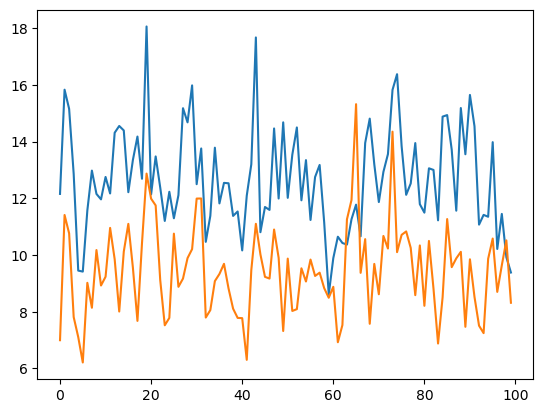

In [19]:
plt.plot(results[0][0])
plt.plot(results[1][0])
plt.show

In [ ]:
import itertools
from joblib import Parallel, delayed


t_values = Parallel(n_jobs=-1)(delayed(get_t_values) for i in range(1))

In [ ]:
from multiprocessing import Pool
import itertools

if __name__ == '__main__':
    pool = Pool(processes=24)
    results_ = []
    result = pool.map(shuffle_y, [y]*100)
    results_.append(result)
    pool.close()
    pool.join()

# Visualization of the Accuracy of the Models

In [ ]:
mean_accuracies = np.mean(model_accuracies, axis=(2)) # Create an array storing the average accuracies for each channel at each timepoint
mean_accuracies_max = np.zeros((num_channels,2))

for channel in range(num_channels):
    mean_accuracies_max[channel, 0] = mean_accuracies[channel,:].max()
    mean_accuracies_max[channel, 1] = list(mean_accuracies[channel]).index(mean_accuracies[channel,:].max()) # the time point at which the maximum accuracy occurs

top_ten_accuracies_index = np.argsort(mean_accuracies_max[:,0])[-10:] # store the channel indices of the top 10 accuracies 

In [ ]:
print(np.argsort(mean_accuracies_max[:,0]))
print(top_ten_accuracies_index)
print(mean_accuracies_max[top_ten_accuracies_index])

In [ ]:
# Plot the mean accuracy vs time graph of the top 10 channels with the highest accuracy

fig, axs = plt.subplots(10, 1, figsize=(24, 48))

time = np.arange(0, 100, 1)

for i, channel in enumerate(top_ten_accuracies_index):
    ax = axs[i]
    ax.plot(time, mean_accuracies[channel])
    ax.set_title('Channel #%i' %(channel + 1))
    ax.set_ylabel('Mean Accuracy')
    ax.set_xlabel('Time')
    ax.axvspan(mean_accuracies_max[channel,1],mean_accuracies_max[channel,1]+.1,color = 'red', alpha=0.5)
    # ax.annotate('local max', xy=(40, .5))
    ax.annotate(f'(Time: {mean_accuracies_max[channel,1]:.0f}, Accuracy: {mean_accuracies_max[channel,0]:.2f})', xy=(mean_accuracies_max[channel,1] + 1,.5))

plt.savefig('top_ten_accuracies.png')
plt.show()

In [ ]:
plt.savefig('top_ten_accuracies.png')

## Covariance matrices

In [ ]:
import seaborn as sns

cov = np.cov(mean_accuracies)
sns.heatmap(cov)

In [ ]:
cov_max = np.zeros((num_channels,2))
cov_diag = np.zeros((num_channels))

for channel in range(num_channels):
    # cov_max[channel] = cov[channel].max() # Used to sanity check that cov_diag == cov_max
    cov_temp = cov[channel, np.arange(num_channels) != channel] # Get the entire row 
    cov_max[channel,0] = cov_temp.max()
    cov_max[channel,1] = int(list(cov_temp).index(cov_temp.max())) # Get the corresponding channel that has the highest covariance
    cov_diag[channel] = cov[channel,channel]

In [ ]:
# print(cov_diag)
# print(cov_max)
# print(cov[0,0])

# print(cov_diag==cov_max) # Used to sanity check that cov_diag == cov_max
# print(cov_max/cov_diag)

# print(cov_max[0])

cov_ratio = (cov_max[:,0]/cov_diag) # Get the ratios of the maximum value of the covariance (non-diagonal) to the value of the diagonal
cov_index = []

for i, covariance in enumerate(cov_ratio):
     if covariance > .5:
            cov_index.append(i)

print(cov_index)


In [ ]:
# Prints the mean accuracy vs time graphs of the channels with the highest covariance

fig, axs = plt.subplots(len(cov_index), 1, figsize=(24, 48))

time = np.arange(0, 100, 1)

for i, channel in enumerate(cov_index):
    ax = axs[i]
    ax.plot(time, mean_accuracies[channel])
    ax.set_title('Channel #%i' %(channel + 1))
    ax.set_ylabel('Mean Accuracy')
    ax.set_xlabel('Time')

plt.show()

# Extraneous Code

## Perform sanity check on decision values 

In [ ]:
X = data[:,1,:,1]
lda = LinearDiscriminantAnalysis(solver = 'lsqr', shrinkage='auto')
cv = cross_validate(lda, X,y, cv=5, return_estimator=True) 
test_scores = cv['test_score']
max_index = list(test_scores).index(test_scores.max())
best_lda = cv['estimator'][max_index]
# print(y)
print(best_lda.decision_function(X).shape)
print(best_lda.predict_proba(X).shape)

## Data Visualization

In [ ]:
from matplotlib import cm

# Plot the PSD graph of Subject 06, Trial #1, Channel #1
fig = plt.figure()
ax = plt.axes(projection="3d")

time = np.arange(0,100,1)
wavlet_freqs = np.logspace(np.log2(2),np.log2(150),num=63,base=2)

x1, y1 = np.meshgrid(time,wavlet_freqs)

surf = ax.plot_surface(x1, y1, data[0,0], cmap='inferno')
ax.set_title('Power')
ax.set_ylabel('Time')
ax.set_xlabel('Frequency')

fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()